In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import h5py
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from scipy.signal import savgol_filter, medfilt

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
from scipy.optimize import curve_fit, minimize


In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py'>

In [2]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
# data_dir = '/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

file = f'{data_dir}/sphere_data/sphere_20241202_recon_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['recon_data_all']
    hist = g['hist'][:]
    n_window = g['hist'].attrs['n_windows']
    scaling = g['hist'].attrs['scaling']

    rate_all = g['rate_hist'][:]
    rate_all_err = g['rate_hist_err'][:]
    bc = g['bc'][:]

    time_all = g.attrs['time_hours']

    fout.close()

file = f'{data_dir}/sphere_data/sphere_20241202_calibration_all.h5py'
with h5py.File(file, 'r') as fout:
    g = fout['calibration_data_processed']
    eff_coefs = g['sig_efficiency_fit_params'][:]
    fout.close()

## New fit 20250131

In [3]:
def crystal_ball_rev(x, alpha, n, mu, sigma):
    # Modified from https://arxiv.org/pdf/1603.08591
    # and https://en.wikipedia.org/wiki/Crystal_Ball_function

    x = np.asarray(x)
    ret = np.empty_like(x)

    A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    # Flip the direction to get the tail on the positive side
    idx_gaus = ((x - mu) / sigma) < alpha
    idx_other = ((x - mu) / sigma) > alpha

    # Flip `B - ...` to `B + ...` to reverse the power law tail 
    ret[idx_gaus] = np.exp(-1 * (x[idx_gaus] - mu)**2 / (2 * sigma**2))
    ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))

    return ret

def crystal_ball_rev_normalized(x, alpha, n, mu, sigma):
    xx = np.linspace(0, 50000, 5000)
    func_val = crystal_ball_rev(xx, alpha, n, mu, sigma)
    norm = np.trapz(func_val, xx)

    x = np.asarray(x)
    if x.size == 1:
        return crystal_ball_rev(x, alpha, n, mu, sigma)[0] / norm
    else:
        return crystal_ball_rev(x, alpha, n, mu, sigma) / norm

def expo_corrected(x, cutoff, xi):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 5000)

    expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < cutoff] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    ret = np.exp(-1 * (x) / xi) / xi
    ret[x < cutoff] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm

In [4]:
def get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot):
    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = a * crystal_ball_rev_normalized(bi, alpha, n, mu, sigma) + (1 - a) * expo_corrected(bi, cutoff, xi)
    mui = ntot * joint_pdf * 50

    return mui

def nll(a, alpha, n, mu, sigma, cutoff, xi, bc, hist):
    idx = bc > 1000
    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    mui = get_mui(a, alpha, n, mu, sigma, cutoff, xi, bi, ntot)
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [5]:
def plot_likelihood_fit(bc, hist, res_x):
    fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])
    ana_threshold = 1000

    idx = bc > ana_threshold
    bi = bc[idx]
    ntot = np.sum(hist)

    hist_norm = n_window * scaling

    hist_fit_ml = get_mui(*res_x, bi, ntot)
    a, alpha, n, mu, sigma, cutoff, xi = res_x

    ax = axes[0]
    ax.fill_betweenx(np.logspace(-1, 9, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.errorbar(bi, hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)
    ax.plot(bi, hist_fit_ml, '--', color='#DC143C', label='Reversed Crystal Ball + exponential (ML)')

    xx2 = np.linspace(1020, 10000, 500)
    crystal_ball_hist = ntot * 50 * a * crystal_ball_rev_normalized(xx2, alpha, n, mu, sigma)
    ax.fill_between(xx2, 0, crystal_ball_hist, color='#E1BE6A', alpha=0.25)

    xx1 = np.linspace(cutoff, 10000, 500)
    expo_hist = ntot * 50 * (1 - a) * expo_corrected(xx1, cutoff, xi)
    ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

    ax.set_yscale('log')
    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-1, 1e9)

    ax.set_yticks(np.logspace(-1, 9, 11))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.legend(frameon=False)
    ax.set_xticklabels([''])
    ax.set_ylabel('Counts / (50 keV/c)')

    ax = axes[1]
    ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
    ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, ana_threshold, color='#B0C4DE', alpha=0.5)

    ax.set_xlim(0, 8000)
    ax.set_ylim(-150, 150)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.set_xlabel('Reconstructed amplitude (keV/c)')
    ax.set_ylabel('Residual ($\sigma_{\mathrm{stat}}$)')

    fig.suptitle('Sphere 20241202')
    fig.tight_layout()

    return fig, axes

/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/1597628168.py:18: RuntimeWarning: invalid value encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))
/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/164037734.py:8: RuntimeWarning: overflow encountered in power
  A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/164037734.py:17: RuntimeWarning: invalid value encountered in multiply
  ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))


Optimization terminated successfully.
         Current function value: -152178767.020342
         Iterations: 341
         Function evaluations: 914
[9.99996691e-01 3.47276545e+00 1.79826520e+02 5.93489570e-05
 2.88315304e+02 1.43999985e+03 2.46167595e+02]


/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/4214219789.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])
/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/4214219789.py:43: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


(<Figure size 700x800 with 2 Axes>,
 array([<Axes: ylabel='Counts / (50 keV/c)'>,
        <Axes: xlabel='Reconstructed amplitude (keV/c)', ylabel='Residual ($\\sigma_{\\mathrm{stat}}$)'>],
       dtype=object))

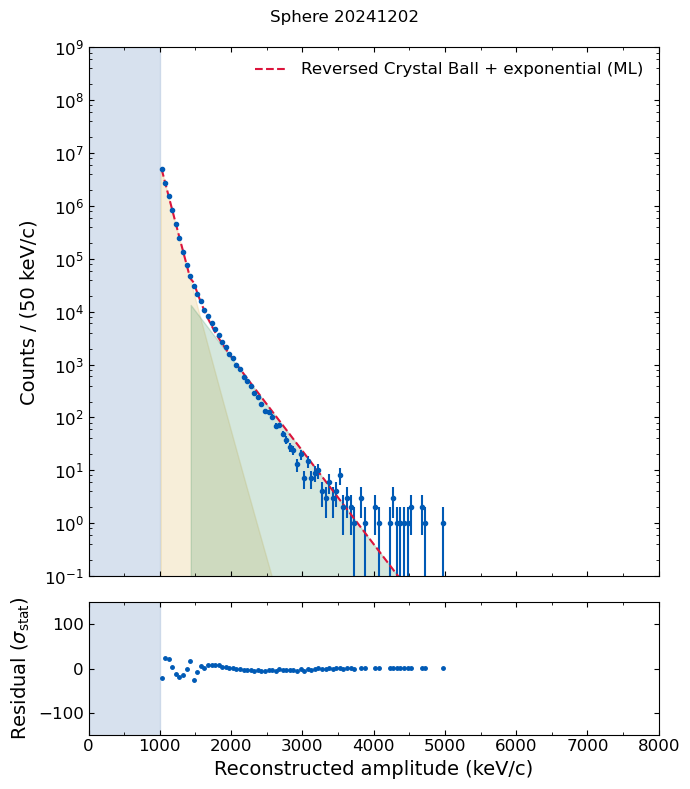

In [55]:
ntot = np.sum(hist)
args = (bc, hist)

res = minimize(fun=lambda x: nll(*x, *args), 
               method='Nelder-Mead',
               x0 = [9.99996691e-01, 3.47276550e+00, 1.79826520e+02, 5.90524207e-05, 2.88315304e+02, 1440, 246],
            #    bounds = [(0.9999, 1), (2, 10), (0, 300), (0, 100), (200, 300), (1200, 1800), (100, 300)],
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'adaptive': True,
                        'fatol': 0.0001,
                        }
               )

param_nodm = res.x
nll_nodm   = res.fun

print(res.x)
plot_likelihood_fit(bc, hist, res.x)

In [3]:
data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'

def get_upper_alpha(mx, alpha_list, nlls):
    if mx < 2:
        return np.nan

    # Remove nan from the nlls
    _nlls = nlls[~np.isnan(nlls)]
    _alpha = alpha_list[~np.isnan(nlls)]
    if _nlls.size == 0:
        return np.nan
    
    if np.max(alpha_list) < 1e-5:  # very fine search at the bottom
        mf_size = 7
        sav_size = 20
    else:
        mf_size = 5
        sav_size = 4

    # _nlls = smooth_nlls(_alpha, _nlls)
    # Remove spikes and smooth nlls using a median filer
    # and a polynomial filter
    _nlls = medfilt(_nlls, mf_size)
    _nlls = savgol_filter(_nlls, sav_size, 1)

    # Ignore the last index after filtering
    idx_ml = np.argmin(_nlls[:-1])

    if np.max(_nlls - _nlls[idx_ml]) < 5:
        return np.nan

    # Make sure NLLs are strictly increasing above the
    # maximum likelihood alpha
    idx_search = (_alpha >= _alpha[idx_ml])
    if np.sum(idx_search) == 1:
        return np.nan
    
    for i in range(np.sum(idx_search)):
        if i == 0: continue
        if _nlls[idx_ml + i] < _nlls[idx_ml + i - 1]:
            idx_search[i] = False

    delta_nlls = _nlls[idx_search] - _nlls[idx_ml]

    return np.interp(4, 2*delta_nlls, _alpha[idx_search], left=np.nan, right=np.nan)

def get_alpha_limits(mphi, sphere, dataset='coarse'):
    nlls_file = np.load(fr'{data_dir}/profile_nlls/{sphere}/profile_nlls_{sphere}_{mphi:.0e}_{dataset}.npz')

    nlls = nlls_file['nll']
    mx_list, alpha_list = nlls_file['mx'], nlls_file['alpha']

    alpha_upper = np.empty(mx_list.size)
    for i, mx in enumerate(mx_list):
        alpha_upper[i] = get_upper_alpha(mx, alpha_list, nlls[i])

    return mx_list, alpha_upper, alpha_list, nlls

def update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_fine, alpha_lim_fine):
    ret = np.copy(alpha_lim_coarse)
    for i, mx_coarse in enumerate(mx_list_coarse):
        if mx_coarse < np.min(mx_list_fine) or mx_coarse > np.max(mx_list_fine):
            continue
        idx = np.argmin(np.abs(mx_list_fine - mx_coarse))
        ret[i] = alpha_lim_fine[idx]

    return ret

def get_combined_limits(lim_coarse, lim_fine_left, lim_fine_bottom=None, lim_fine_side=None):
    mx_list_left, alpha_lim_left = lim_fine_left[0], lim_fine_left[1]
    mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 5], lim_coarse[1][lim_coarse[0] > 5]

    mx_list_full = np.concatenate([mx_list_left, mx_list_coarse])

    ## Update alpha limits based on finer calculation (but keep the coarse mx list)
    if lim_fine_bottom is not None:
        mx_list_bottom, alpha_lim_bottom = lim_fine_bottom[0], lim_fine_bottom[1]
        alpha_lim_coarse = update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_bottom, alpha_lim_bottom)

        if lim_fine_side is not None:
            mx_list_side, alpha_lim_side = lim_fine_side[0], lim_fine_side[1]
            alpha_lim_coarse = update_alpha_lim(mx_list_coarse, alpha_lim_coarse, mx_list_side, alpha_lim_side)

    alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_coarse])

    # if lim_fine_bottom is not None:
    #     mx_list_bottom, alpha_lim_bottom = lim_fine_bottom[0], lim_fine_bottom[1]

    #     if lim_fine_side is None:
    #         mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 30], lim_coarse[1][lim_coarse[0] > 30]

    #         mx_list_full = np.concatenate([mx_list_left, mx_list_bottom, mx_list_coarse])
    #         alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_bottom, alpha_lim_coarse])
    #     else:
    #         mx_list_side, alpha_lim_side = lim_fine_side[0], lim_fine_side[1]
    #         mx_list_coarse, alpha_lim_coarse = lim_coarse[0][lim_coarse[0] > 1000], lim_coarse[1][lim_coarse[0] > 1000]

    #         mx_list_full = np.concatenate([mx_list_left, mx_list_bottom, mx_list_side, mx_list_coarse])
    #         alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_bottom, alpha_lim_side, alpha_lim_coarse])
    # else:
    #     alpha_lim_full = np.concatenate([alpha_lim_left, alpha_lim_coarse])

    mx_list_full, idx_unique = np.unique(mx_list_full, return_index=True)
    return mx_list_full, alpha_lim_full[idx_unique]

In [4]:
lim_10ev_coarse = get_alpha_limits(10, 'sphere_20241202', 'coarse')
lim_1ev_coarse = get_alpha_limits(1, 'sphere_20241202', 'coarse')
lim_0_1ev_coarse = get_alpha_limits(0.1, 'sphere_20241202', 'coarse')
lim_0_01ev_coarse = get_alpha_limits(0.01, 'sphere_20241202', 'coarse')

lim_10ev_fine_left = get_alpha_limits(10, 'sphere_20241202', 'fine_left')
lim_1ev_fine_left = get_alpha_limits(1, 'sphere_20241202', 'fine_left')
lim_0_1ev_fine_left = get_alpha_limits(0.1, 'sphere_20241202', 'fine_left')
lim_0_01ev_fine_left = get_alpha_limits(0.01, 'sphere_20241202', 'fine_left')

lim_1ev_veryfine_bottom = get_alpha_limits(1, 'sphere_20241202', 'veryfine_bottom')
lim_0_1ev_veryfine_bottom = get_alpha_limits(0.1, 'sphere_20241202', 'veryfine_bottom')
lim_0_01ev_veryfine_bottom = get_alpha_limits(0.01, 'sphere_20241202', 'veryfine_bottom')

lim_0_1ev_fine_side = get_alpha_limits(0.1, 'sphere_20241202', 'fine_side')
lim_0_01ev_fine_side = get_alpha_limits(0.01, 'sphere_20241202', 'fine_side')

In [5]:
lim_0_01ev_veryfine_bottom[1]

array([           nan,            nan, 2.68223423e-07, 2.81811389e-07,
       2.91091725e-07, 2.91269299e-07, 2.99259573e-07, 3.07663121e-07,
       3.10741597e-07, 3.37238407e-07, 3.52806519e-07, 3.62915561e-07,
       3.82061560e-07, 3.94729688e-07, 4.21834883e-07, 4.29885866e-07,
       4.40606363e-07, 4.73942443e-07, 5.14849831e-07, 5.33176471e-07,
       5.68468738e-07, 5.86083121e-07, 6.44837750e-07, 6.80983169e-07,
       7.26810438e-07, 7.51898518e-07, 8.02771828e-07])

(1, 10000.0)

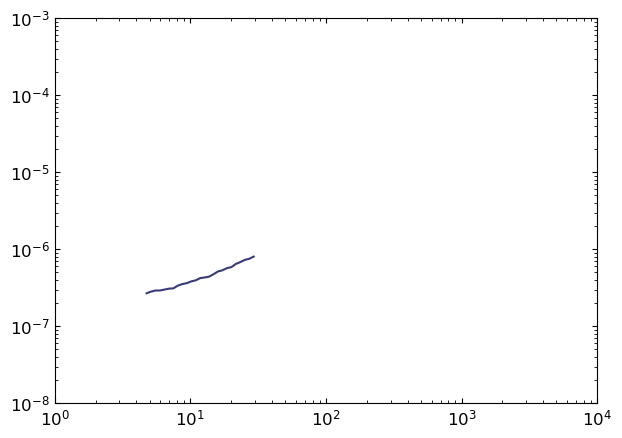

In [24]:
# plt.plot(lim_10ev_coarse[0], lim_10ev_coarse[1])
# plt.plot(lim_1ev_coarse[0], lim_1ev_coarse[1])
# # plt.plot(lim_0_1ev_coarse[0], lim_0_1ev_coarse[1])
# plt.plot(lim_0_01ev_coarse[0], lim_0_01ev_coarse[1])
plt.plot(lim_0_01ev_veryfine_bottom[0], lim_0_01ev_veryfine_bottom[1])

plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-8, 1e-3)
plt.xlim(1, 1e4)

In [6]:
lim_0_01ev_veryfine_bottom

(array([ 4.09111893,  4.41302962,  4.76026992,  5.13483291,  5.53886848,
         5.97469568,  6.44481605,  6.95192796,  7.49894209,  8.08899816,
         8.72548294,  9.41204967, 10.15263908, 10.95150193, 11.81322351,
        12.74274986, 13.74541621, 14.8269776 , 15.99364192, 17.2521055 ,
        18.60959159, 20.0738918 , 21.65341083, 23.35721469, 25.19508277,
        27.17756395, 29.31603714]),
 array([           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
        3.21408141e-07, 3.35874827e-07, 3.51183118e-07, 3.78050291e-07,
        4.00805277e-07, 4.37860549e-07, 4.64706406e-07, 4.92722682e-07,
        5.30449250e-07, 5.70707967e-07, 6.05778935e-07, 6.56298980e-07,
        7.09084235e-07, 7.32011296e-07, 7.90421765e-07]),
 array([1.00000000e-07, 1.01486963e-07, 1.02996037e-07, 1.04527550e-07,
        1.06081836e-07, 1.07659233e-0

In [11]:
lim_0_01ev_coarse[1][31]

nan

(0.0, 1000.0)

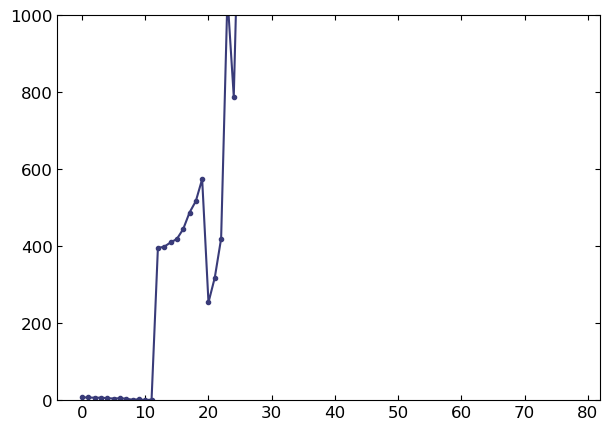

In [12]:
i = 31

plt.plot(lim_0_01ev_coarse[-1][i] - np.min(lim_0_01ev_coarse[-1][i]), '.-')
# plt.plot(lim_0_01ev_veryfine_bottom[-2], lim_0_01ev_veryfine_bottom[-1][i] - np.min(lim_0_01ev_veryfine_bottom[-1][i]), '.-')


plt.ylim(0, 1000)
# plt.xscale('log')

In [13]:
for j in range(10, 15):
    print(j, lim_0_01ev_coarse[-1][i][j])

10 2491.9825692772865
11 2493.51053199172
12 2887.1956446766853
13 2890.557903200388
14 2901.437209814787


In [21]:
import calc_profile_nlls as calc_nlls

import importlib
importlib.reload(calc_nlls)

calc_nlls.load_sphere_data('sphere_20241202')

i_mx = 31
i_alpha_begin, i_alpha_end = 10, 15

_nlls = []
_params = []
mx = lim_0_01ev_coarse[0][i_mx]
for alpha in lim_0_01ev_coarse[2][i_alpha_begin:i_alpha_end]:
    res = calc_nlls.minimize_nll(0.01, mx, alpha)

    print(res.fun)
    print(res.x)

    _nlls.append(res.fun)
    _params.append(res.x)


/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../calc_profile_nlls.py:112: RuntimeWarning: overflow encountered in power
  A = np.power(n / np.abs(alpha), n) * np.exp(-1 * alpha**2 / 2)
/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../calc_profile_nlls.py:121: RuntimeWarning: invalid value encountered in multiply
  ret[idx_other] = A * np.power((B + (x[idx_other] - mu) / sigma), (-1 * n))
/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../calc_profile_nlls.py:203: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui))) + gaus_term + neut_term + nll_offset
/vast/palmer/home.grace/yt388/microspheres/dm_nanospheres/analysis_notebooks/../calc_profile_nlls.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(mui - ni * np.log(mui))) + gaus_term + neut_term + nll_offset


-10.768771678209305
[9.99996826e-01 3.47296667e+00 1.79828626e+02 6.18422392e-05
 2.88316126e+02 1.45027809e+03 2.44933051e+02 9.99999701e-01
 1.00000021e+00]
-5.422906905412674
[9.99996828e-01 3.47300338e+00 1.79829010e+02 6.18668208e-05
 2.88316256e+02 1.44592328e+03 2.44681458e+02 9.99999699e-01
 1.00000006e+00]
-4.055399715900421
[9.99996697e-01 3.47307246e+00 1.79829733e+02 6.20323756e-05
 2.88316549e+02 1.44006966e+03 2.44156745e+02 9.99999971e-01
 9.99999846e-01]
1.7819882035255432
[9.99996699e-01 3.47314187e+00 1.79830460e+02 6.24919842e-05
 2.88316821e+02 1.43885681e+03 2.43731169e+02 1.00000002e+00
 1.00000025e+00]
14.944158405065536
[9.99996702e-01 3.47320243e+00 1.79831094e+02 6.25896683e-05
 2.88317004e+02 1.43963751e+03 2.43208323e+02 9.99999785e-01
 1.00000014e+00]


In [6]:
combined_lim_10ev = get_combined_limits(lim_10ev_coarse, lim_10ev_fine_left)
combined_lim_1ev = get_combined_limits(lim_1ev_coarse, lim_1ev_fine_left)
combined_lim_0_1ev = get_combined_limits(lim_0_1ev_coarse, lim_0_1ev_fine_left, lim_0_1ev_fine_side)
combined_lim_0_01ev = get_combined_limits(lim_0_01ev_coarse, lim_0_01ev_fine_left, lim_0_01ev_fine_side)

# Bad index
# bad_idx_1ev = [34, 35]
# for i in bad_idx_1ev:
#     combined_lim_1ev[1][i] = np.interp(combined_lim_1ev[0][i], [combined_lim_1ev[0][33], combined_lim_1ev[0][36]], 
#                                                                [combined_lim_1ev[1][33], combined_lim_1ev[1][36]])

bad_idx_0_01ev = [4, 5]
combined_lim_0_01ev[1][bad_idx_0_01ev] = np.nan


Text(0, 0.5, '95% CL upper limit on $\\alpha_n$')

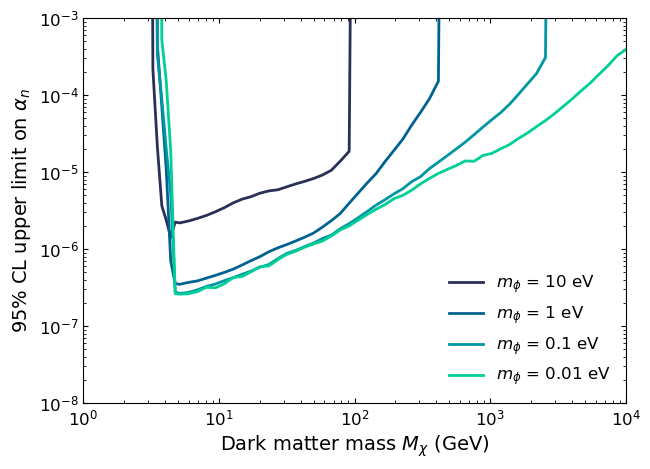

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70Z']

ax.plot(combined_lim_10ev[0], np.nan_to_num(combined_lim_10ev[1], nan=1e10),     '-', label='$m_\phi$ = 10 eV', color=colors[0], linewidth=2)
ax.plot(combined_lim_1ev[0], np.nan_to_num(combined_lim_1ev[1], nan=1e10),       '-', label='$m_\phi$ = 1 eV', color=colors[1], linewidth=2)
ax.plot(combined_lim_0_1ev[0], np.nan_to_num(combined_lim_0_1ev[1], nan=1e10),   '-', label='$m_\phi$ = 0.1 eV', color=colors[2], linewidth=2)
ax.plot(combined_lim_0_01ev[0], np.nan_to_num(combined_lim_0_01ev[1], nan=1e10), '-', label='$m_\phi$ = 0.01 eV', color=colors[3], linewidth=2)

plt.xlim(1e0, 1e4)
plt.ylim(1e-8, 1e-3)

plt.yscale('log')
plt.xscale('log')

plt.legend(frameon=False)
plt.xlabel(r'Dark matter mass $M_\chi$ (GeV)')
plt.ylabel(r'95% CL upper limit on $\alpha_n$')

In [31]:
lim_1ev_veryfine_bottom[1]

array([           nan, 6.60605334e-07, 3.50606542e-07, 3.60878789e-07,
       3.68249200e-07, 3.79433030e-07, 3.91056635e-07, 4.05077472e-07,
       4.20198249e-07, 4.37265983e-07, 4.53001011e-07, 4.70919733e-07,
       4.95653033e-07, 5.17012920e-07, 5.43389409e-07, 5.70653751e-07,
       6.07194695e-07, 6.45821418e-07, 6.81783459e-07, 7.28452597e-07,
       7.76872773e-07, 8.25774248e-07, 8.89608576e-07,            nan,
                  nan,            nan,            nan])

In [7]:
lim_1ev_[1]

array([8.14264622e-07, 8.63770906e-07, 9.53288195e-07, 9.82936277e-07,
       1.01507627e-06, 1.08153327e-06, 1.15756239e-06,            nan,
       1.29587979e-06, 1.38546041e-06, 1.39585051e-06, 1.61378456e-06,
       1.74572134e-06, 1.93910202e-06, 1.98723180e-06, 2.21783035e-06,
       2.40644170e-06, 2.50675491e-06, 2.75812397e-06, 2.91704271e-06,
       3.26996466e-06, 3.44615814e-06, 3.64283928e-06, 4.03732630e-06,
       4.44588118e-06, 4.66010516e-06, 4.97326973e-06, 5.60495414e-06,
       6.03559546e-06, 6.33429124e-06, 7.13207126e-06, 7.52797085e-06,
       8.00953695e-06, 8.66322198e-06, 9.25584395e-06, 9.81463426e-06,
       1.08033551e-05, 1.09671951e-05, 1.16631241e-05, 1.22073938e-05,
       1.35018041e-05, 1.35408839e-05, 1.44285178e-05, 1.46848243e-05,
       1.64608145e-05, 1.67637060e-05])

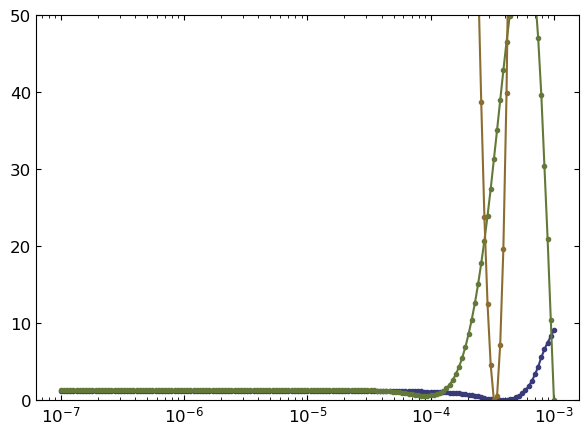

In [30]:
_alphas = lim_1ev_fine_left[-2]

for i in range(5, 8):
    mx = lim_1ev_fine_left[0][i]
    _nlls = lim_1ev_fine_left[-1][i]

    _nlls = medfilt(_nlls, 5)
    _nlls = savgol_filter(_nlls, 5, 1)

    idx_ml = np.argmin(_nlls[:-1])
    # print(idx_ml)
    # print(get_upper_alpha(mx, _alphas, _nlls))
    plt.plot(_alphas, _nlls - np.min(_nlls), '.-')

plt.ylim(0, 50)
plt.xscale('log')

In [114]:
import calc_profile_nlls as calc_nlls

import importlib
importlib.reload(calc_nlls)

x0_bg = np.array([9.99999963e-01, 3.88844938e+00, 1.88930977e+01, 1.64962666e+02, 2.55454974e+02, 1.70317112e+03, 3.73851449e+02])

mx = lim_0_01ev_fine_side[0][0]
_alphas = lim_0_01ev_fine_side[-2]


_nlls = []
_params = []
for alpha in lim_0_01ev_fine_side[2][115:120]:
    res = calc_nlls.minimize_nll(0.01, mx, alpha, x0_bg)

    print(res.fun)
    print(res.x)

    _nlls.append(res.fun)
    _params.append(res.x)





Optimization terminated successfully.
         Current function value: 25919.764049
         Iterations: 1609
         Function evaluations: 2732
25919.76404863596
[1.00000000e+00 3.07065414e+00 3.50544983e+01 1.86178990e+02
 2.38621627e+02 3.77538512e+03 5.98733176e+02 1.99421965e+00
 5.00000000e-01]
Optimization terminated successfully.
         Current function value: 28067.485227
         Iterations: 3097
         Function evaluations: 5127
28067.485227406025
[1.00000000e+00 2.81562862e+00 3.77815313e+01 2.54421646e+02
 2.15708324e+02 3.32335086e+03 4.15974248e+02 1.98927294e+00
 5.00000000e-01]
Optimization terminated successfully.
         Current function value: 30115.893464
         Iterations: 4940
         Function evaluations: 8963
30115.89346435666
[1.00000000e+00 3.13460528e+00 4.05906399e+01 1.57478130e+02
 2.47025888e+02 9.04291621e+03 8.37546923e+02 2.00000000e+00
 5.00000000e-01]


In [112]:
_params

[array([9.99998240e-01, 9.93462366e-01, 4.53518542e+01, 4.64206463e+02,
        7.03577870e+01, 1.57031406e+03, 2.38887697e+02, 1.98133348e+00,
        1.95626984e-02]),
 array([9.99999123e-01, 1.71620928e+00, 2.63853792e+01, 4.60663191e+02,
        1.13571638e+02, 1.72034407e+03, 2.33045640e+02, 9.88304095e-01,
        1.51691945e-02]),
 array([9.99999662e-01, 3.17098553e+00, 1.83654660e+01, 2.02438108e+02,
        2.35240048e+02, 1.92500000e+03, 2.28928006e+02, 8.60783120e-01,
        1.49595659e-02])]

## Old results

In [180]:
xx = np.linspace(1, 9950, 9950)
ff = func2(xx, *eff_coefs)

# Signal efficiency for each bin
eff_binned = np.mean(np.reshape(ff, (199, 50)), axis=1)
eff_binned[bc < 800] = 0  # Choose a 800 keV analysis threshold

In [940]:
from scipy.special import zeta

def func_fit(x, alpha, sigma, xmin, a):
    eff = func2(x, *eff_coefs)
    total_amp = 1 / (2e-6 * 25)
    
    gaus  = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * x**2 / (2 * sigma**2))
    power_law = np.power(x, -1*a) / zeta(a, xmin)

    return np.log(total_amp * (alpha * gaus + (1 - alpha) * eff * power_law))

def func_fit_expo(x, alpha, sigma, xi):
    eff = func2(x, *eff_coefs)

    # (1 s)/(time per search)
    # no need to divide by bin width because the function
    # is continuous and normalize differently
    total_amp = 1 / (2e-6 * 25)
    
    # Assume zero mean
    # Factor of two because we only have half gaussian
    gaus  = 2 * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * x**2 / (2 * sigma**2))

    # Re-normalize exponential after applying efficiency correction
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)
    expo_corrected_norm = np.trapz(eff_xx * np.exp(-1 * xx / xi) / xi, xx)

    expo_corrected = eff * (np.exp(-1 * x / xi) / xi) / expo_corrected_norm

    return np.log(total_amp * (alpha * gaus + (1 - alpha) * expo_corrected))


In [1118]:
idx_fit = np.logical_and(np.logical_and(bc > 800, hist > 0), bc<3500)

popt_power, pcov_power = curve_fit(func_fit, bc[idx_fit], np.log(rate_all[idx_fit]), p0=[0.99, 287, 800, 10], sigma=np.log(rate_all_err[idx_fit]),
                       bounds=([0.5, 200, 100, 2], [1, 400, 1800, 20]), maxfev=5000)

popt_expo, pcov_expo = curve_fit(func_fit_expo, bc[idx_fit], np.log(rate_all[idx_fit]),
                                 p0=[0.998, 287, 250], sigma=np.log(rate_all_err[idx_fit]),
                                 bounds=([0.9, 200, 100], [1, 400, 2000]), maxfev=5000)

In [1205]:
def gaus_corrected(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    gaus_corrected_norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / gaus_corrected_norm

def half_gaus(x, sigma):
    return 2 * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x)**2 / (2 * sigma**2))

def expo_corrected(x, b, xi, eff_coefs=None):
    # Re-normalize exponential after applying efficiency correction 
    # and truncate from below
    xx = np.linspace(0, 50000, 50000)

    if eff_coefs is not None:
        eff_xx = func2(xx, *eff_coefs)
        expo_eff_truncated = eff_xx * np.exp(-1 * (xx) / xi) / xi
    else:
        expo_eff_truncated = np.exp(-1 * (xx) / xi) / xi
    expo_eff_truncated[xx < b] = 0

    expo_corrected_norm = np.trapz(expo_eff_truncated, xx)

    x = np.asarray(x)
    if eff_coefs is not None:
        eff_x = func2(x, *eff_coefs)
        ret = eff_x * np.exp(-1 * (x) / xi) / xi
    else:
        ret = np.exp(-1 * (x) / xi) / xi
    ret[x < b] = 0

    if ret.size == 1:
        return ret[0] / expo_corrected_norm
    else:
        return ret / expo_corrected_norm
    
def power_law_corrected(x, xmin, a, eff_coefs):
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)

    power_law_eff = eff_xx * np.power(xx, -1 * a) / zeta(a, xmin)
    power_law_eff[xx < xmin] = 0

    power_law_corrected_norm = np.trapz(power_law_eff, xx)

    x = np.asarray(x)
    eff_x = func2(x, *eff_coefs)
    
    ret = eff_x * np.power(x, -1 * a) / zeta(a, xmin)
    ret[x < xmin] = 0

    if ret.size == 1:
        return ret[0] / power_law_corrected_norm
    else:
        return ret / power_law_corrected_norm

def laplace_corrected(x, b, xi, eff_coefs):
    xx = np.linspace(0, 50000, 50000)
    eff_xx = func2(xx, *eff_coefs)

    laplace_eff = eff_xx * np.exp(-1 * np.abs(xx - b) / xi) / (2 * xi)
    laplace_corrected_norm = np.trapz(laplace_eff, xx)

    eff_x = func2(x, *eff_coefs)
    
    ret = eff_x * np.exp(-1 * np.abs(x - b) / xi) / (2 * xi)
    return ret / laplace_corrected_norm

def half_gaus_expo(x, b, sigma, xi, eff_coefs):
    xx = np.linspace(0, 50000, 50000)

    xx_low = xx[xx < b]
    _half_gaus = half_gaus(xx_low, sigma)

    xx_high = xx[xx > b]
    eff_xx = func2(xx_high, *eff_coefs)
    _expo_eff = eff_xx * np.exp(-1 * (xx_high) / xi) / xi

    func_all = np.empty_like(xx)
    func_all[xx < b] = _half_gaus
    func_all[xx > b] = _expo_eff
    _norm = np.trapz(func_all, xx)

    x = np.asarray(x)
    ret = np.empty_like(x)

    eff_x_high = func2(x[x>b], *eff_coefs)
    
    ret[x < b] = half_gaus(x[x<b], sigma)
    ret[x > b] = eff_x_high * np.exp(-1 * (x[x>b]) / xi) / xi

    if ret.size == 1:
        return ret[0] / _norm
    else:
        return ret / _norm

def half_gaus_mod(x, mu, m, n):
    xx = np.linspace(0, 50000, 50000)
    sigma = m * xx + n
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    sigma_x = m * x + n
    return (1 / (np.sqrt(2 * np.pi) * sigma_x)) * np.exp(-1 * (x - mu)**2 / (2 * sigma_x**2)) / _norm

def half_gaus_mod_fixed(x, mu, sigma):
    xx = np.linspace(0, 50000, 50000)
    _norm = np.trapz((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (xx - mu)**2 / (2 * sigma**2)), xx)

    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2)) / _norm

In [1560]:
def nll(alpha, mu, m, n, b, xi, bc, hist, eff_coefs=None):
# def nll(alpha, mu, sigma, b, xi, bc, hist, eff_coefs=None):
    # idx = np.logical_and(bc > 800, bc < 3000)
    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    ntot = np.sum(hist)

    # Expected number of count in each bin
    # fi = np.empty_like(ni, dtype=np.float64)
    # for i, bc in enumerate(bi):
    #     be_lower = bc - 25
    #     be_upper = bc + 25

    #     xx = np.linspace(be_lower, be_upper, 25)
    #     joint_pdf = alpha * half_gaus_mod(xx, mu, m, n) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs=None)
    #     # joint_pdf = alpha * half_gaus_mod_fixed(xx, mu, sigma) + (1 - alpha) * expo_corrected(xx, b, xi=xi, eff_coefs=None)

    #     fi[i] = np.trapz(joint_pdf, xx)
    # mui = ntot * fi

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50

    # third_term = np.asarray([0 if ni[i]==0 else ni[i] * np.log(ni[i] / mui[i]) for i in range(ni.size)])
    # return 2 * np.sum(mui - ni + third_term)

    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


In [1585]:
from scipy.optimize import minimize

ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.9999, 200, 5e-2, 180, 1300, 200],
               method='COBYQA',
               bounds=[(0.99, 1), (0, 300), (0, 0.1), (150, 300), (1000, 1500), (100, 250)],
               tol=1e-6,
               options={'disp' : True,
                        'maxiter': 10000,
                        'maxfev': 10000,
                        'scale': True,
                        }
               )
print(res.x)

Starting the optimization procedure.
Initial trust-region radius: 1.0.
Final trust-region radius: 1e-06.
Maximum number of function evaluations: 10000.
Maximum number of iterations: 10000.

<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1492426244.3709135
<lambda>([ 9.950e-01  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1399446859.0259392
<lambda>([ 1.000e+00  3.000e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1663405624.5917888
<lambda>([ 1.000e+00  1.500e+02  1.000e-01  1.500e+02  1.250e+03  1.750e+02]) = -1660998521.9705691
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  2.250e+02  1.250e+03  1.750e+02]) = -1631994755.3105679
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.500e+03  1.750e+02]) = -1492426244.3709135
<lambda>([ 1.000e+00  1.500e+02  5.000e-02  1.500e+02  1.250e+03  2.500e+02]) = -1492426244.3709135
<lambda>([ 9.900e-01  1.500e+02  5.000e-02  1.500e+02  1.250e+03  1.750e+02]) = -1300312634.7376575
<lambda>([

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/3958049937.py:33: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/3958049937.py:33: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.nan_to_num(mui - ni * np.log(mui)))


<lambda>([ 1.000e+00  2.273e+02  7.060e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940000.1250474
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940010.809517
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940024.9286442
<lambda>([ 1.000e+00  2.273e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940046.2169752
<lambda>([ 1.000e+00  2.272e+02  7.059e-02  1.591e+02  1.328e+03  2.004e+02]) = -1666940067.5509756
<lambda>([ 1.000e+00  2.272e+02  7.058e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940114.9751723
<lambda>([ 1.000e+00  2.271e+02  7.058e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940164.807981
<lambda>([ 1.000e+00  2.270e+02  7.057e-02  1.592e+02  1.328e+03  2.004e+02]) = -1666940239.4085164
<lambda>([ 1.000e+00  2.268e+02  7.057e-02  1.593e+02  1.328e+03  2.004e+02]) = -1666940360.0599868
<lambda>([ 1.000e+00  2.266e+02  7.058e-02  1.594e+02  1.329e+03  2.004e+02]) = -1666940492.0966098
<l

In [1591]:
def hist_fit_likelihood(bcs, ntot, alpha, mu, m, n, b, xi):
# def hist_fit_likelihood(bcs, ntot, alpha, mu, sigma, b, xi):

    # return ntot * 50 * (alpha * gaus_corrected(bcs, mu, sigma) + (1 - alpha) * expo_corrected(bcs, mu, xi, eff_coefs))
    return ntot * 50 * (alpha * half_gaus_mod(bcs, mu, m, n) + (1 - alpha) * expo_corrected(bcs, b, xi, eff_coefs))

    # fi = np.empty_like(bcs, dtype=np.float64)
    # for i, bc in enumerate(bcs):
    #     be_lower = bc - 25
    #     be_upper = bc + 25

    #     xx = np.linspace(be_lower, be_upper, 100)
    #     joint_pdf = alpha * half_gaus_mod(xx, mu, m, n) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs)
    #     # joint_pdf = alpha * half_gaus_mod_fixed(xx, mu, sigma) + (1 - alpha) * expo_corrected(xx, b, xi, eff_coefs)
    #     fi[i] = np.trapz(joint_pdf, xx)
        
    # mui = ntot * fi
    # return mui

<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:53: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''])
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_13958/2071276090.py:46: RuntimeWarning: divide by zero encountered in divide
  ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')


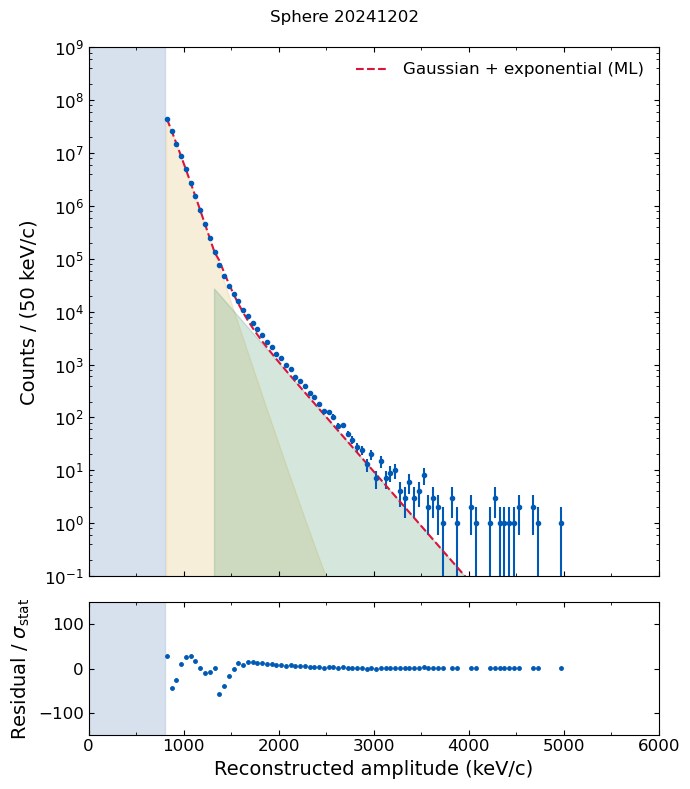

In [1584]:
fig, axes = plt.subplots(2, 1, figsize=(7, 8), height_ratios=[4, 1])

ntot = np.sum(hist)
alpha, mu, m, n, b, xi = res.x

idx = bc > 800
hist_norm = n_window * scaling

hist_fit_ls = hist_norm * np.exp(func_fit_expo(bc[idx], popt_expo[0], popt_expo[1], popt_expo[2]))
hist_fit_ml = hist_fit_likelihood(bc[idx], np.sum(hist), *res.x)

ax = axes[0]
ax.fill_betweenx(np.logspace(-1, 9, 100), 0, 800, color='#B0C4DE', alpha=0.5)
ax.errorbar(bc[idx], hist[idx], yerr=np.sqrt(hist[idx]), fmt='.', color='#005AB5', alpha=1)

# ax.plot(bc[idx], hist_fit_ls, '--', color='#E1BE6A', label='Gaussian + exponential (LS)')
ax.plot(bc[idx], hist_fit_ml, '--', color='#DC143C', label='Gaussian + exponential (ML)')


xx2 = np.linspace(820, 10000, 500)
gaus_hist = ntot * 50 * alpha * half_gaus_mod(xx2, mu, m, n)
ax.fill_between(xx2, 0, gaus_hist, color='#E1BE6A', alpha=0.25)

xx1 = np.linspace(b, 10000, 500)
expo_hist = ntot * 50 * (1 - alpha) * expo_corrected(xx1, b, xi, eff_coefs=None)
ax.fill_between(xx1, 0, expo_hist, color='#2E8B57', alpha=0.2)

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(0, 6000)
ax.set_ylim(1e-1, 1e9)

ax.set_yticks(np.logspace(-1, 9, 11))
locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())

ax.legend(frameon=False)
ax.set_xticklabels([''])
ax.set_ylabel('Counts / (50 keV/c)')

ax = axes[1]
# ax.plot(bc[idx], (hist[idx] - hist_fit_ls) / np.sqrt(hist[idx]), '--', color='#E1BE6A', label='Gaussian + exponential (LS)')
ax.plot(bc[idx], (hist[idx] - hist_fit_ml) / np.sqrt(hist[idx]), '.', color='#005AB5', markersize=5, label='Gaussian + exponential (ML)')
ax.fill_betweenx(np.linspace(-1000, 1000, 100), 0, 800, color='#B0C4DE', alpha=0.5)

ax.set_xlim(0, 6000)
ax.set_ylim(-150, 150)
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Residual / $\sigma_{\mathrm{stat}}$')

fig.suptitle('Sphere 20241202')
fig.tight_layout()

In [ ]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi = 1

In [ ]:
mx = mx_list[15]
qq, drdq, drdqz, drdqzn = [[] for i in range(4)]
for alpha in alpha_list:
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdqz_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.h5py'
    with h5py.File(file, 'r') as f:
        g = f['dm_rate_sampled']
        try:
            qq.append(g.attrs['bin_center_kev'])
        except(KeyError):
            qq.append(g['bin_center_kev'][:])
        drdq.append(g['rate_binned_iso'][:])
        drdqz.append(g['rate_binned_z'][:])
        drdqzn.append(g['rate_binned_z_gaus'][:])

Text(0.5, 0, 'Momentum transfer $q_z$ (keV/c)')

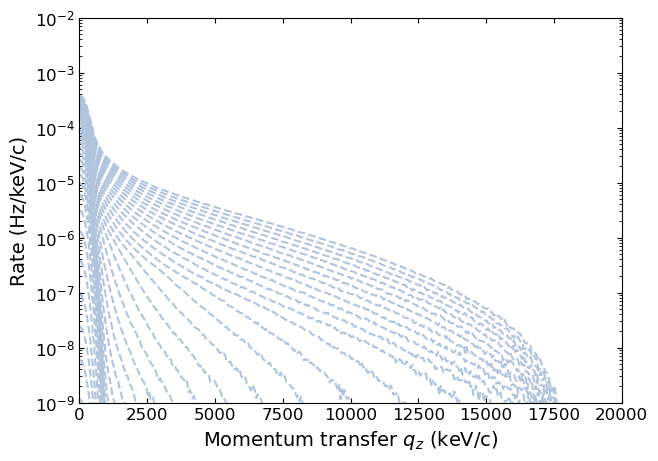

In [ ]:
for i in range(0, 40):
    # plt.plot(qq[i], drdq[i], 'r--')
    # plt.plot(qq[i], drdqz[i], 'g--')
    plt.plot(qq[i], drdqzn[i], '--', color='#B0C4DE')

plt.yscale('log')
plt.ylim(1e-9, 1e-2)
plt.xlim(0, 20000)

plt.ylabel('Rate (Hz/keV/c)')
plt.xlabel('Momentum transfer $q_z$ (keV/c)')

In [1546]:
def read_dm_rate(mphi, mx, alpha):
    R_um       = 0.083
    file = f'/Users/yuhan/work/impulse/yuhan/data/mphi_1e+00/drdqz_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.h5py'
    with h5py.File(file, 'r') as f:
        g = f['dm_rate_sampled']

        try:
            qq = g.attrs['bin_center_kev']
        except(KeyError):
            qq = g['bin_center_kev'][:]
        
        drdqzn = g['rate_binned_z_gaus'][:]
    return qq, drdqzn

def nll_dm(alpha, mu, m, n, b, xi, bc, hist, eff_coefs, mphi, mx, alpha_n, hist_norm):
    qq, drdqzn = read_dm_rate(mphi, mx, alpha_n)
    eff_qq = func2(qq, *eff_coefs)
    hist_dm = eff_qq * drdqzn * hist_norm

    # For large dm couplings that give large kicks
    # zero pad the actual measured histogram
    if qq.size > bc.size:
        hist = np.pad(hist, (0, qq.size - bc.size))
        bc = qq

    idx = bc > 800

    bi = bc[idx]
    ni = hist[idx]

    # Total number of count in the entire range
    # DM events are fixed so profile over other parameters
    ntot = np.sum(hist) - np.sum(hist_dm)

    # Use only the central value of pdf
    # faster and avoid numerical issues from integration
    # No correctiion for efficiency for the background
    joint_pdf = alpha * half_gaus_mod(bi, mu, m, n) + (1 - alpha) * expo_corrected(bi, b, xi, eff_coefs=None)
    mui = ntot * joint_pdf * 50 + hist_dm[idx]

    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))

In [ ]:
ntot = np.sum(hist)
args = (bc, hist, None)
res = minimize(fun=lambda x: nll(*x, *args), x0=[0.9999, 100, 3e-2, 280, 1215, 200],
               method='COBYQA',
               bounds=[(0.99, 1), (0, 300), (0, 0.1), (150, 300), (1000, 1500), (100, 230)],
               options={'disp' : True,
                        'maxfev': 5000,
                        'maxiter': 5000,
                        'scale': True
                        }
               )

In [1547]:
nll = []
for alpha in alpha_list:
    nll.append(nll_dm(*res.x, bc, hist, eff_coefs, mphi, mx_list[15], alpha, hist_norm))

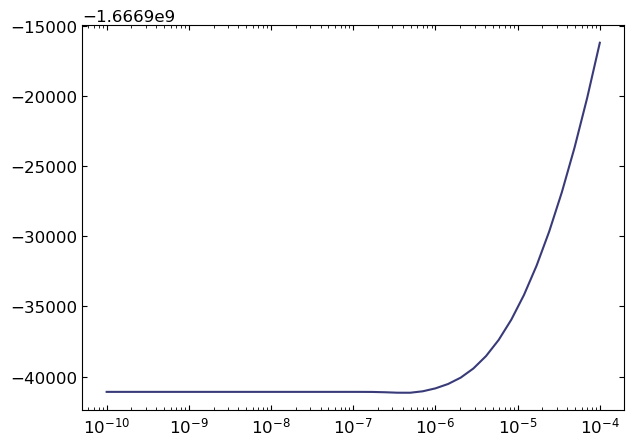

In [1557]:
plt.plot(alpha_list, np.asarray(nll))
plt.xscale('log')

In [1551]:
np.argmin(nll)

24

In [1552]:
alpha_list[24]

4.923882631706742e-07

## Read in the calculated rate

In [137]:
R_um       = 0.083
mx_list    = np.logspace(-2, 5, 40)
alpha_list = np.logspace(-10, -4, 40)
mphi_list = [10, 1, 0.1, 0.01]


In [138]:
rate_dir = '/home/yt388/palmer_scratch/data/dm_rate'

mphi = 1
mx = mx_list[15]
qq, drdq = [], []
for alpha in alpha_list:
    file = f'{rate_dir}/mphi_{mphi:.0e}/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq.append(drdq_npz['q_kev'])
    drdq.append(drdq_npz['drdq_hz_kev'])

mphi = 1
alpha = alpha_list[19]
qq_1, drdq_1 = [], []
for mx in mx_list:
    file = f'{rate_dir}/mphi_{mphi:.0e}/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq_1.append(drdq_npz['q_kev'])
    drdq_1.append(drdq_npz['drdq_hz_kev'])

mx = mx_list[15]
alpha = alpha_list[19]
qq_2, drdq_2 = [], []
for mphi in mphi_list:
    file = f'{rate_dir}/mphi_{mphi:.0e}/drdq_nanosphere_{R_um:.2e}_{mx:.5e}_{alpha:.5e}_{mphi:.0e}.npz'
    drdq_npz = np.load(file)

    qq_2.append(drdq_npz['q_kev'])
    drdq_2.append(drdq_npz['drdq_hz_kev'])



/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/173746401.py:11: RuntimeWarning: divide by zero encountered in log
  axes[0].plot(qq[i], np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), '--' ,label=alpha_label)
/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/173746401.py:14: RuntimeWarning: divide by zero encountered in log
  axes[1].plot(qq_1[i], np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')
/tmp/tmp.jmv0omzU8Z/ipykernel_3369181/173746401.py:17: RuntimeWarning: divide by zero encountered in log
  axes[2].plot(qq_2[i], np.exp(savgol_filter(np.log(drdq_2[i]), 50, 1)), '--', label=f'$m_\phi$ = {mphi_list[i]:.2f} eV')


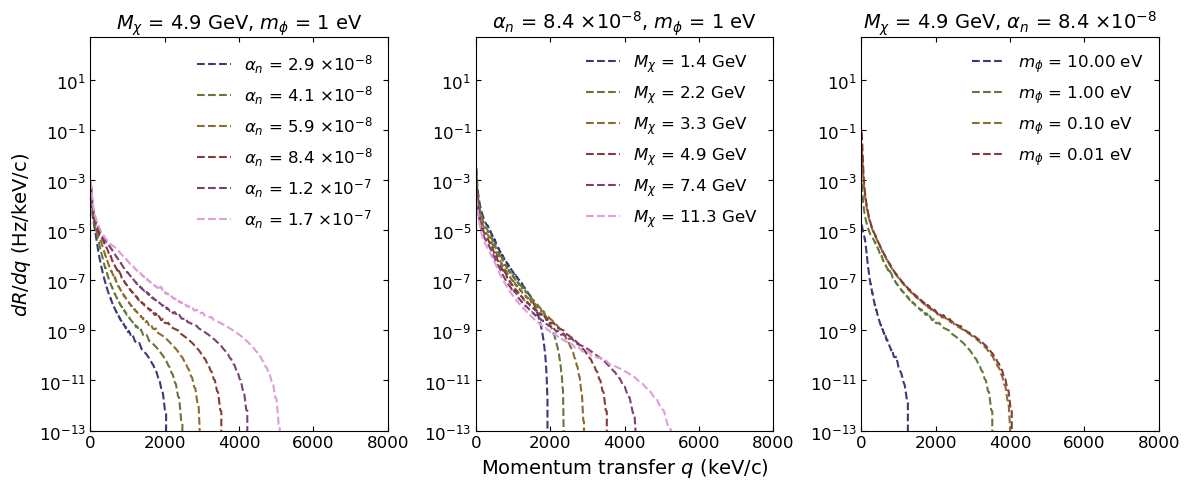

In [145]:
# Plot the calculated event rate projected onto the z axis
# Smooth with a second order filter in the log space for plotting

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i in range(16, 22):
    if alpha_list[i] > 1e-7:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-7:.1f} $\\times 10^{{-7}}$'
    else:
        alpha_label = f'$\\alpha_n$ = {alpha_list[i]/1e-8:.1f} $\\times 10^{{-8}}$'
    axes[0].plot(qq[i], np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), '--' ,label=alpha_label)

for i in range(12, 18):
    axes[1].plot(qq_1[i], np.exp(savgol_filter(np.log(drdq_1[i]), 50, 1)), '--', label=f'$M_\chi$ = {mx_list[i]:.1f} GeV')

for i in range(4):
    axes[2].plot(qq_2[i], np.exp(savgol_filter(np.log(drdq_2[i]), 50, 1)), '--', label=f'$m_\phi$ = {mphi_list[i]:.2f} eV')

for i, ax in enumerate(axes):
    ax.legend(frameon=False)
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylim(1e-13, 500)
    ax.set_xlim(0, 8000)

axes[0].set_ylabel('$dR / dq$ (Hz/keV/c)')
axes[1].set_xlabel('Momentum transfer $q$ (keV/c)')


axes[0].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $m_\phi$ = 1 eV')
axes[1].set_title(f'$\\alpha_n$ = {alpha_list[19]/1e-8:.1f} $\\times 10^{{-8}}$, $m_\phi$ = 1 eV')
axes[2].set_title(f'$M_\chi$ = {mx_list[15]:.1f} GeV, $\\alpha_n$ = {alpha_list[19]/1e-8:.1f} $\\times 10^{{-8}}$')

fig.tight_layout()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/dm_rate_drdqz.pdf', dpi=600)


## Project the event rate onto the $z$-axis

In [ ]:
i = 20
_qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/1812468859.py:2: RuntimeWarning: divide by zero encountered in log
  _qq, _drdq_smoothed = qq[i], np.nan_to_num( np.exp(savgol_filter(np.log(drdq[i]), 50, 1)), nan=0 )


In [ ]:
rand_seed = 22040403
rng = np.random.default_rng(rand_seed)

def get_random_q_samples(qq, drdq, rr):
    norm_factor = np.trapz(drdq, qq)

    f_drdq_norm = drdq / norm_factor       # PDF of q
    Fc_drdq_norm = np.cumsum(f_drdq_norm)  # CDF of q

    qq_sampled = np.interp(rr, Fc_drdq_norm, qq, left=0, right=0)
    return qq_sampled, norm_factor


In [ ]:
n_mc = int(1e8)

rr = rng.uniform(0, 1, n_mc)
phiphi = rng.uniform(0, np.pi, n_mc)
noise_gaussian = rng.normal(0, 200, n_mc)

In [ ]:
qq_sampled, norm = get_random_q_samples(_qq, _drdq_smoothed, rr)

hh, be   = np.histogram(qq_sampled, bins=np.arange(0, 5000, 50), density=True)
hhz, be  = np.histogram(qq_sampled*np.abs(np.cos(phiphi)), bins=np.arange(0, 5000, 50), density=True)
hhzn, be = np.histogram(qq_sampled*np.abs(np.cos(phiphi)) + noise_gaussian, bins=np.arange(0, 5000, 50), density=True)
bc = 0.5 * (be[1:] + be[:-1])

Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

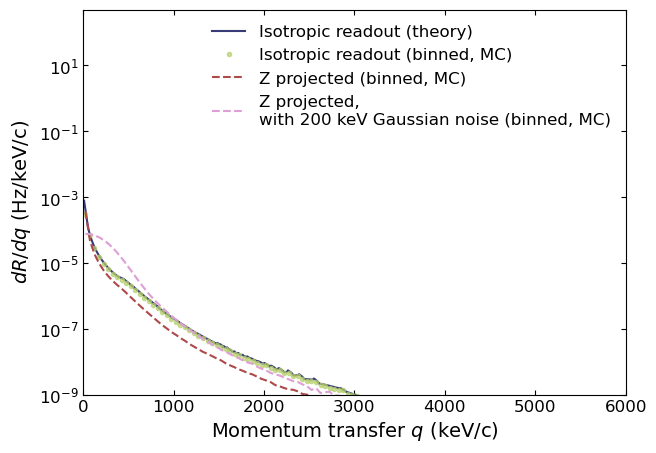

In [ ]:
colors = plt.colormaps.get_cmap('tab20b').resampled(4).colors
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(_qq, _drdq_smoothed, '-', color=colors[0], label=f'Isotropic readout (theory)')
ax.plot(bc, hh*norm, '.', color=colors[1], alpha=0.7, label='Isotropic readout (binned, MC)')
ax.plot(bc, hhz*norm, '--', color=colors[2], label='Z projected (binned, MC)')
ax.plot(bc, hhzn*norm, '--', color=colors[3], label='Z projected, \nwith 200 keV Gaussian noise (binned, MC)')

ax.legend(frameon=False)

ax.set_ylim(1e-9, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')

## Incorrect implementation!

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_64558/3117880255.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')


Text(0, 0.5, '$dR / dq$ (Hz/keV/c)')

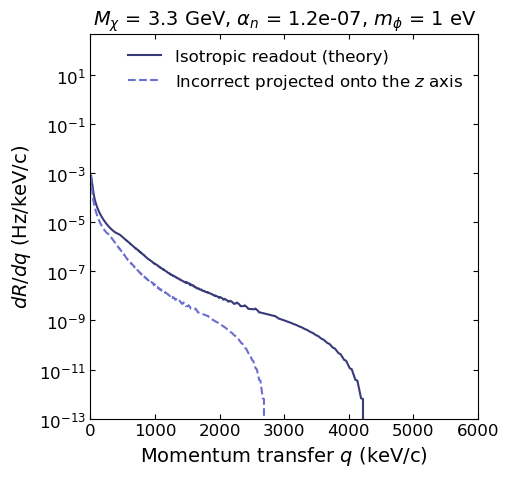

In [ ]:
# Because <|cos theta|> = 2 / pi if theta is uniformly 
# distributed from 0 to pi
# This is incorrected! Because the tail should remain the same

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(_qq, _drdq_smoothed, '-' ,label=f'Isotropic readout (theory)')
ax.plot(_qq * 2 / np.pi, _drdq_smoothed, '--' ,label=f'Incorrect projected onto the $z$ axis')

ax.set_title(f'$M_\chi$ = {mx_list[14]:.1f} GeV, $\\alpha_n$ = {alpha_list[i]:.1e}, $m_\phi$ = 1 eV')
ax.legend(frameon=False)

ax.set_ylim(1e-13, 500)
ax.set_xlim(0, 6000)
ax.set_yscale('log')

ax.set_xlabel('Momentum transfer $q$ (keV/c)')
ax.set_ylabel('$dR / dq$ (Hz/keV/c)')